In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

In [2]:
from datetime import datetime

def mostrar_tiempo(df):    
    dic_events_time = {}
    person = ""
    rows = []
    compra = False
    for index, row in df.iterrows():
        if(person == ""):
            person = row["person"]
            last_event_time = row['timestamp']
            continue            
        if(row['event'] == 'conversion'):
            compra = True
        if(tiempo = (datetime.strptime(last_event_time,"%Y-%m-%d %H:%M:%S") \
                                       - datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S")).total_seconds())>86400):
            last_event_time = row['timestamp']
        if (row['new_vs_returning'] == 'New' or row['new_vs_returning'] == 'Returning' or person != row["person"]):
            if(row['person'] != person):
                tiempo = 0
            rows.append([person,tiempo,row['timestamp'],compra])
            person = ""
            compra = False
    return pd.DataFrame(rows,columns=('person', 'time_event', 'timestamp','realizo_compra'))

In [3]:
datos = pd.read_csv("events_up_to_01062018.csv",low_memory=False)

In [4]:
h = datos[['person','timestamp','event','new_vs_returning']]
h = h.sort_values(by=['person','timestamp'],ascending=False)
g = mostrar_tiempo(h)

In [7]:
g = g.sort_values(by='time_event',ascending=False)
g = g.loc[g['time_event']>0]

In [8]:
datos = pd.merge(datos,g,on=['person','timestamp'],how='left')

In [9]:
datos['timestamp'] = pd.to_datetime(datos['timestamp'])
datos['dia'] = datos['timestamp'].dt.day
datos['mes'] = datos['timestamp'].dt.month

In [10]:
quincenas = [False,0,2,4,6,8,10]

datos['mes_q'] = datos['mes'].apply(lambda x: quincenas[x])

datos['principio_fin'] = 0
datos.loc[datos['dia'] >15,'principio_fin'] = 1

datos['quincena'] = datos['principio_fin'] + datos['mes_q']

In [138]:
datos_tiempo = datos[['person','mes','time_event']]
datos_tiempo.fillna(0,inplace=True)
datos_tiempo = datos_tiempo.groupby(['person','mes']).agg({'time_event':'max'})

/home/mariano/ENTER/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [139]:
datos_tiempo = datos_tiempo.unstack()
datos_tiempo.columns = datos_tiempo.columns.droplevel(0)
datos_tiempo = datos_tiempo.reset_index(level=0,drop=False)


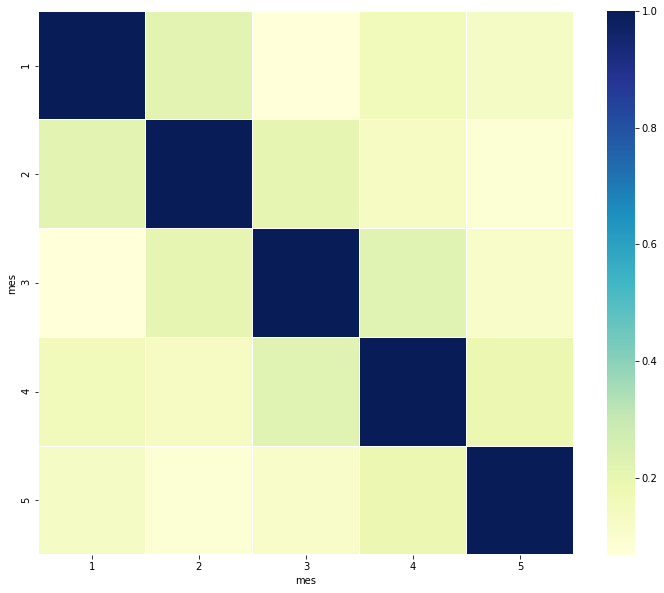

In [117]:

corrmat = datos_tiempo.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

In [118]:
j = 0
for i in datos_tiempo.columns:
    datos_tiempo.rename(columns={j:'prom_tiempo_'+str(j)},inplace=True)
    j =  j + 1

In [119]:
datos_tiempo.fillna(0,inplace=True)

In [130]:
datos

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,screen_resolution,operating_system_version,browser_version,time_event,realizo_compra,dia,mes,mes_q,principio_fin,quincena
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
5,2018-05-18 00:44:27,searched products,4c8a8b93,NaN,NaN,NaN,NaN,NaN,NaN,"10240,9987,10322,10085,9944,9931,13404,10154,1...",...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
6,2018-05-18 00:44:14,viewed product,1b9f7cf6,NaN,2831.0,iPhone 6,Bom,16GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
7,2018-05-18 00:44:02,viewed product,29ebb414,NaN,2845.0,iPhone 6 Plus,Bom,128GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
8,2018-05-18 00:43:59,viewed product,de8fe91b,NaN,12548.0,Motorola Moto G5 Plus,Bom,32GB,Platinum,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
9,2018-05-18 00:43:40,ad campaign hit,45baf068,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9


In [120]:
compras = datos.loc[datos['event'] == 'conversion',['person','mes','timestamp']]
compras = compras.groupby(['person','mes']).count()

compras = compras.unstack().fillna(0)
compras.columns = compras.columns.droplevel(0)

j = 1
for i in compras.columns:
    compras.rename(columns={j:'compras_'+str(j)},inplace=True)
    j =  j + 1

In [104]:
#for i in compras_por_q:
#    compras.loc[compras[i]>0,i] = 1
#compras

In [121]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index(level=0,drop=False)
eventos_x_person.fillna(0,inplace=True)

In [122]:
train = pd.read_csv("labels_training_set.csv",low_memory=False)

In [123]:
dat = pd.merge(compras,datos_tiempo,on='person')
train = pd.merge(train,dat,on='person')

In [124]:
train = pd.merge(train,eventos_x_person,on='person')

In [125]:
features = train.iloc[:,2:].columns

In [126]:
from sklearn.model_selection import train_test_split

test_s = 0.20
random_s = 0

x = np.array(train[train.iloc[:,2:].columns])
y = np.array(train['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_s, random_state=random_s)

In [127]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

print('VALORES INICIALES PARA K')

k_valores = [5,7,10,20,50]
mejor_k = 0
mejor_precision = 0

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(np.array(y_test), pred)
    print('La precisión para k=', k, 'es:',precision)
    if precision > mejor_precision:
        mejor_precision = precision
        mejor_k = k
        
print('Con k=', mejor_k, 'se obtuvo la mayor precisión:', mejor_precision)

VALORES INICIALES PARA K
La precisión para k= 5 es: 0.5187208527648234
La precisión para k= 7 es: 0.4962025316455696
La precisión para k= 10 es: 0.5
La precisión para k= 20 es: 0.5
La precisión para k= 50 es: 0.5
Con k= 5 se obtuvo la mayor precisión: 0.5187208527648234


In [128]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train.iloc[:,2:],train['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [129]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    print('"' + name + '"'+" : ",importance,',')

"compras_1" :  0.004663555102461646 ,
"compras_2" :  0.0030751278284910076 ,
"compras_3" :  0.01880526887349649 ,
"compras_4" :  0.011588653923926774 ,
"compras_5" :  0.05302804521279802 ,
"prom_tiempo_1" :  0.014197164483843401 ,
"prom_tiempo_2" :  0.013353259587674906 ,
"prom_tiempo_3" :  0.02864244491723424 ,
"prom_tiempo_4" :  0.048455508876188436 ,
"prom_tiempo_5" :  0.14391942895907492 ,
"ad campaign hit" :  0.06987898730000756 ,
"brand listing" :  0.07661804683567573 ,
"checkout" :  0.06433466127513733 ,
"conversion" :  0.0314763475324362 ,
"generic listing" :  0.08302472237736688 ,
"lead" :  0.008353381775315895 ,
"search engine hit" :  0.06189898732828197 ,
"searched products" :  0.05821302697081557 ,
"staticpage" :  0.03158607466625108 ,
"viewed product" :  0.10066915926621106 ,
"visited site" :  0.0742181469073108 ,


In [131]:
train.to_csv('train_final.csv', encoding='utf-8', index=False)

# IDEAS
-SI compro recientemente

-Hace cuanto no se loggea en la pagina

-Antiguedad en la pagina

In [266]:
def logueoycompras(df):
    rows=[]
    person = ""
    for index,row in df.iterrows():
        if((row['event'] == 'conversion') & (person == "")):
            dia_conversion = row['timestamp']
            person = row['person']
            continue
        if(person != ""):
            dias = row['timestamp'].timetuple().tm_yday -\
                dia_conversion.timetuple().tm_yday
            if(person!=row['person']):
                dias = datetime(2018, 6, 1, 0, 0).timetuple().tm_yday -\
                        dia_conversion.timetuple().tm_yday
            if dias > 1:
                rows.append([person,dia_conversion.timetuple().tm_yday,dias])
                person = ""
    return pd.DataFrame(rows,columns=('person','day_of_year','dias_sin_conversion'))

In [260]:
datetime(2018, 6, 1, 0, 0).timetuple().tm_yday

152

In [233]:
compra_sesion = datos[['person','timestamp','event']]
compra_sesion = compra_sesion.loc[(datos['event']=='conversion') | (datos['event']=='visited site')]
compra_sesion.sort_values(by=['person','timestamp'],ascending=True,inplace=True)
compra_sesion

,person,timestamp,event
2336760,0008ed71,2018-05-17 13:44:59,visited site
2336761,0008ed71,2018-05-17 16:21:54,visited site
2146920,00091926,2018-05-03 22:08:29,visited site
2146921,00091926,2018-05-05 03:43:24,visited site
2146922,00091926,2018-05-05 23:30:31,visited site
2146923,00091926,2018-05-06 02:04:51,visited site
2146924,00091926,2018-05-07 00:31:06,visited site
2146925,00091926,2018-05-08 23:30:44,visited site
2146926,00091926,2018-05-09 00:25:05,visited site
2146927,00091926,2018-05-10 00:37:38,visited site


In [251]:
compra_sesion['dayofyear'] = compra_sesion.timestamp.dt.dayofyear
compra_sesion.head(80)

,person,timestamp,event,dayofyear
2336760,0008ed71,2018-05-17 13:44:59,visited site,137
2336761,0008ed71,2018-05-17 16:21:54,visited site,137
2146920,00091926,2018-05-03 22:08:29,visited site,123
2146921,00091926,2018-05-05 03:43:24,visited site,125
2146922,00091926,2018-05-05 23:30:31,visited site,125
2146923,00091926,2018-05-06 02:04:51,visited site,126
2146924,00091926,2018-05-07 00:31:06,visited site,127
2146925,00091926,2018-05-08 23:30:44,visited site,128
2146926,00091926,2018-05-09 00:25:05,visited site,129
2146927,00091926,2018-05-10 00:37:38,visited site,130


In [267]:
i = logueoycompras(compra_sesion)
i

,person,day_of_year,dias_sin_conversion
0,000ba417,146,6
1,001001be,136,3
2,001804a2,145,3
3,0019e639,40,3
4,0019e639,142,10
5,001b0bf9,142,10
6,0020152e,150,2
7,002aea56,30,2
8,002ed810,145,3
9,002ed810,149,3


In [ ]:
compra_sesion

In [265]:
pd.options.display.max_rows = 4000

compra_sesion.loc[compra_sesion['person'].str.startswith('02')]

,person,timestamp,event,dayofyear
2191802,02005e21,2018-05-16 11:37:39,visited site,136
2191803,02005e21,2018-05-16 12:23:26,visited site,136
2191804,02005e21,2018-05-16 12:56:46,visited site,136
2191805,02005e21,2018-05-16 13:58:53,visited site,136
2191806,02005e21,2018-05-16 16:26:57,visited site,136
2231637,02005e21,2018-05-16 22:01:59,visited site,136
2231638,02005e21,2018-05-16 23:14:52,visited site,136
55988,02005e21,2018-05-16 23:21:32,conversion,136
2191807,02005e21,2018-05-17 01:20:46,visited site,137
2191808,02005e21,2018-05-17 12:50:15,visited site,137


In [154]:
datos.sample()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,operating_system_version,browser_version,time_event,realizo_compra,dia,mes,mes_q,principio_fin,quincena,compro
155794,2018-05-21 12:22:28,viewed product,eb40c8c1,NaN,7617.0,Motorola Moto G3 4G,Bom,16GB,Branco,NaN,...,NaN,NaN,NaN,NaN,21,5,8,1,9,NaN


In [155]:
datos.event.value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64